In [1]:
%load_ext watermark
%watermark -a 'cs224' -u -d -v -p numpy,xarray,scipy,pandas,sklearn,matplotlib,seaborn,pymc3,gpflow,GPy,tensorflow,tensorflow_probability

cs224 
last updated: 2020-04-25 

CPython 3.6.10
IPython 7.13.0

numpy 1.18.1
xarray 0.15.0
scipy 1.4.1
pandas 1.0.2
sklearn 0.22.1
matplotlib 3.1.3
seaborn 0.10.0
pymc3 3.8
gpflow 2.0.1
GPy 1.9.9
tensorflow 2.1.0
tensorflow_probability 0.9.0


In [2]:
%matplotlib inline
import numpy as np, scipy, scipy.stats as stats, scipy.special, scipy.misc, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, xarray as xr
import matplotlib as mpl

import pymc3 as pm

import theano as thno
import theano.tensor as T

import sklearn, sklearn.linear_model

import datetime, time, math
from dateutil import relativedelta

from collections import OrderedDict

SEED = 42
np.random.seed(SEED)

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
np.set_printoptions(edgeitems=10)
np.set_printoptions(linewidth=1000)
np.set_printoptions(suppress=True)
np.core.arrayprint._line_width = 180

sns.set()
# sns.set_style("whitegrid")

In [3]:
from IPython.display import display, HTML

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        if type(df) == np.ndarray:
            df = pd.DataFrame(df)
        html_str+=df.to_html()
    html_str = html_str.replace('table','table style="display:inline"')
    # print(html_str)
    display_html(html_str,raw=True)

CSS = """
.output {
    flex-direction: row;
}
"""

def display_graphs_side_by_side(*args):
    html_str='<table><tr>'
    for g in args:
        html_str += '<td>'
        html_str += g._repr_svg_()
        html_str += '</td>'
    html_str += '</tr></table>'
    display_html(html_str,raw=True)
    

display(HTML("<style>.container { width:70% !important; }</style>"))

In [4]:
%load_ext autoreload
%autoreload 1
%aimport covid19

* [Corona-Hub von www.npgeo.de](https://npgeo-corona-npgeo-de.hub.arcgis.com/)
    * [RKI COVID19](https://npgeo-corona-npgeo-de.hub.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0)
    * [CSV](https://opendata.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0.csv)
    * [Robert Koch-Institut: COVID-19-Dashboard](https://npgeo-corona-npgeo-de.hub.arcgis.com/app/478220a4c454480e823b17327b2bf1d4)
* [Priesemann-Group/covid19_inference_forecast](https://github.com/Priesemann-Group/covid19_inference_forecast/commit/4d34d342cd8e58c18b5107ce38c537d4e83bc561)
    * [data_retrieval.py](https://github.com/Priesemann-Group/covid19_inference_forecast/blob/master/covid19_inference/data_retrieval.py)

* [data source description](https://www.arcgis.com/home/item.html?id=f10774f1c63e40168479a1feb6c7ca74)

In [5]:
df_   = pd.read_csv('https://www.arcgis.com/sharing/rest/content/items/f10774f1c63e40168479a1feb6c7ca74/data')

In [6]:
df_.head()

,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,ObjectId,Meldedatum,IdLandkreis,Datenstand,NeuerFall,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen
0,1,Schleswig-Holstein,LK Steinburg,A15-A34,W,1,0,3650921,2020-03-25T00:00:00.000Z,1061,"25.04.2020, 00:00 Uhr",0,-9,2020-03-16T00:00:00.000Z,0,1
1,1,Schleswig-Holstein,LK Steinburg,A15-A34,W,1,0,3650922,2020-03-27T00:00:00.000Z,1061,"25.04.2020, 00:00 Uhr",0,-9,2020-03-22T00:00:00.000Z,0,1
2,1,Schleswig-Holstein,LK Steinburg,A15-A34,W,1,0,3650923,2020-04-01T00:00:00.000Z,1061,"25.04.2020, 00:00 Uhr",0,-9,2020-03-21T00:00:00.000Z,0,1
3,1,Schleswig-Holstein,LK Steinburg,A15-A34,W,1,0,3650924,2020-04-06T00:00:00.000Z,1061,"25.04.2020, 00:00 Uhr",0,-9,2020-03-22T00:00:00.000Z,0,1
4,1,Schleswig-Holstein,LK Steinburg,A15-A34,W,1,0,3650925,2020-04-07T00:00:00.000Z,1061,"25.04.2020, 00:00 Uhr",0,-9,2020-03-31T00:00:00.000Z,0,1


In [7]:
df_['AnzahlFall'].sum()

152367

In [8]:
lds = df_['Bundesland']
len(lds.unique()), lds.unique()

(16,
 array(['Schleswig-Holstein', 'Hamburg', 'Niedersachsen', 'Nordrhein-Westfalen', 'Bremen', 'Hessen', 'Rheinland-Pfalz', 'Baden-Württemberg', 'Bayern', 'Saarland', 'Berlin', 'Mecklenburg-Vorpommern', 'Sachsen', 'Brandenburg', 'Sachsen-Anhalt', 'Thüringen'], dtype=object))

In [9]:
def timeline(in_df, state=None, county=None, time_anchor_column_name='Refdatum', count_column_name='AnzahlFall'):
    ldf = in_df.copy()
    if state is not None:
        ldf = ldf[ldf['Bundesland'] == state].copy()
    if county is not None:
        ldf = ldf[ldf['Landkreis'] == county].copy()
    ldf[time_anchor_column_name] = pd.to_datetime(ldf[time_anchor_column_name]).dt.tz_localize(None)
    ldf = ldf.set_index(time_anchor_column_name)
    ldf.index.name = 'index'
    lds = ldf[count_column_name].resample('D').sum()
    return lds

In [10]:
def create_rki_df(in_df, state=None, county=None, time_anchor_column_name='Meldedatum'):
    lds_confirmed = timeline(df_, state=state, county=county, time_anchor_column_name=time_anchor_column_name, count_column_name='AnzahlFall')
    lds_recovered = timeline(df_, state=state, county=county, time_anchor_column_name=time_anchor_column_name, count_column_name='AnzahlGenesen')
    lds_death     = timeline(df_, state=state, county=county, time_anchor_column_name=time_anchor_column_name, count_column_name='AnzahlTodesfall')
    ldf = pd.DataFrame()
    ldf['confirmed'] = lds_confirmed.cumsum()
    ldf['recovered'] = lds_recovered.cumsum()
    ldf['death']     = lds_death.cumsum()
    
    ldf['new_confirmed'] = lds_confirmed
    ldf['new_recovered'] = lds_recovered
    ldf['new_death']     = lds_death
    return ldf

In [11]:
# create_rki_df(df_)

In [12]:
cbr_germany = covid19.CasesByRegion('Germany', df=create_rki_df(df_))
cbr_germany.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-04-20,145225,109205,5426,1702,213,45
2020-04-21,147389,109389,5459,2164,184,33
2020-04-22,149778,109521,5483,2389,132,24
2020-04-23,151554,109611,5493,1776,90,10
2020-04-24,152367,109646,5496,813,35,3


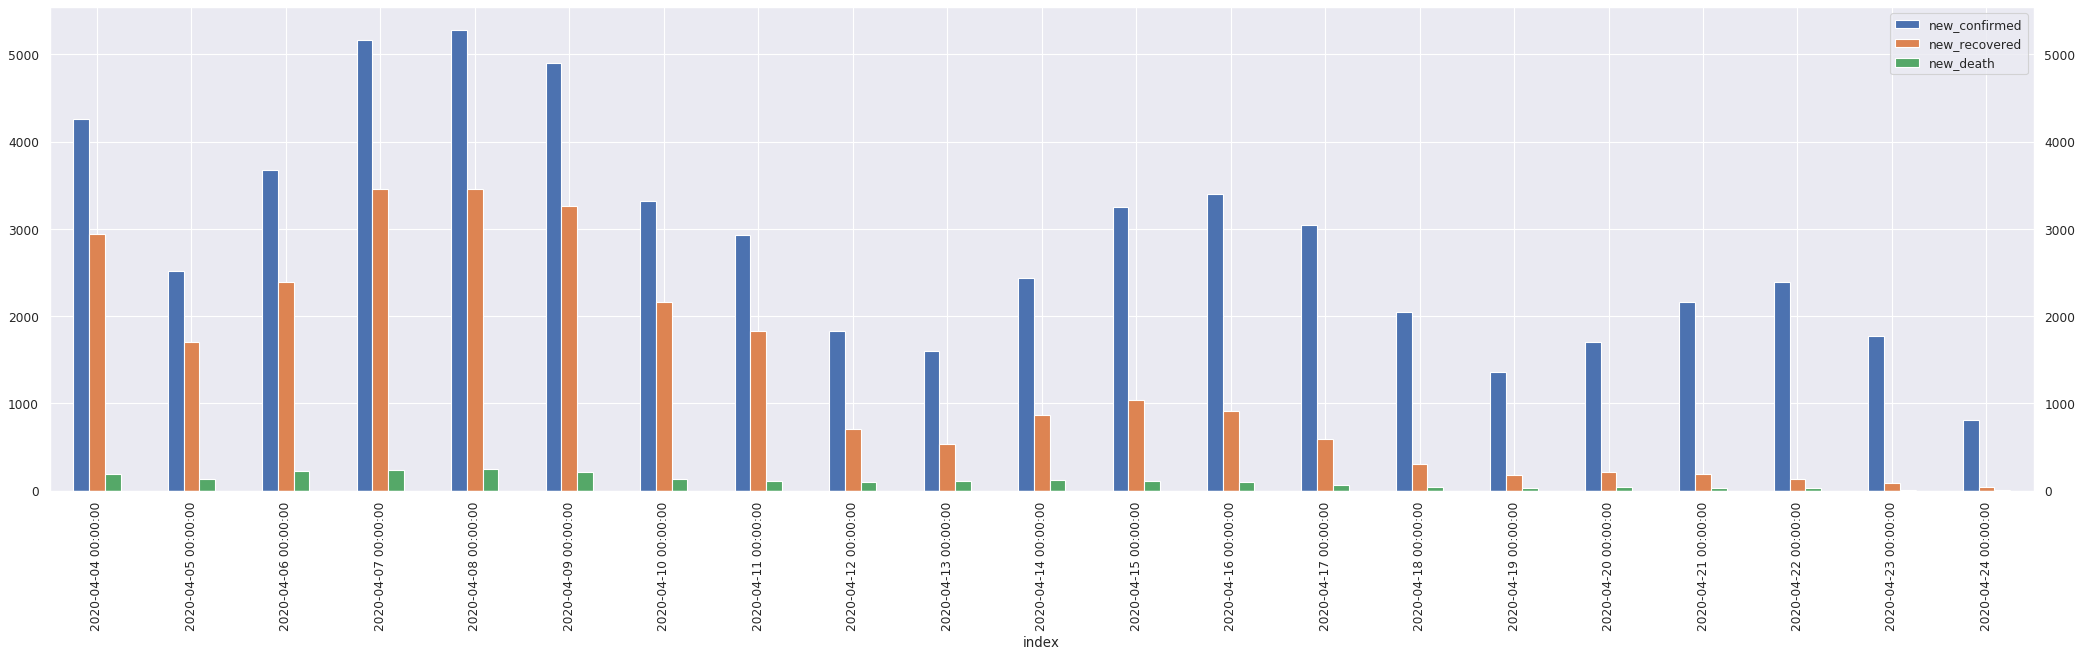

In [13]:
cbr_germany.plot_daily_stats()

sigmoid+linear 2020-08-01 00:00:00 [102058.18756549      0.18336917    -11.17168999  10576.21787232] 0.0136025838407281 1939.3523191077647


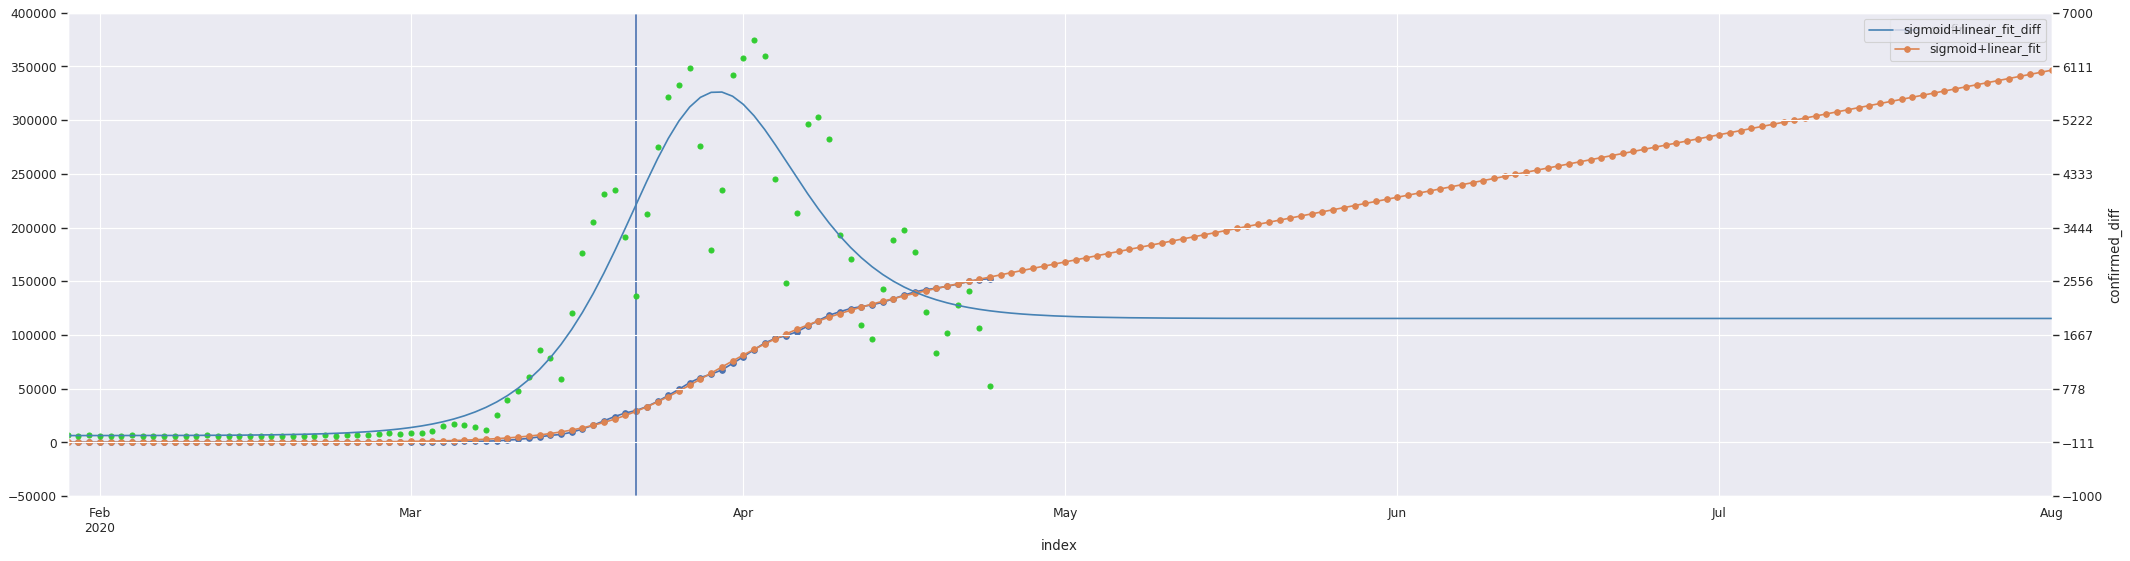

In [14]:
country_name, first_date, init_add, restriction_start_date = 'Germany', pd.to_datetime('2020-03-09'), 0, datetime.datetime(2020, 3, 22)
ldf, lpopt, lpcov, lsqdiff, lgrowthRate, idx, label = covid19.prepare_country_prediction(country_name, in_df=cbr_germany.df, first_date=first_date, init_add=init_add, range_append_nr_entires=100)
if len(lpopt) == 4:
    steady_state_rate = lpopt[1] * lpopt[3]
else:
    steady_state_rate = 0.0
print(label, ldf.index[-1], lpopt, lgrowthRate, steady_state_rate)
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ldf[['confirmed', label + '_fit']].iloc[1:,:].plot(ax=ax, marker=mpl.path.Path.unit_circle(), markersize=5);
ax.axvline(restriction_start_date);

ax2 = ax.twinx()
ldf[[label + '_fit_diff']].iloc[1:,:].plot(ax=ax2, color=['steelblue']);
lbl = 'confirmed' + '_diff'
ldf[[lbl]].iloc[1:,:].reset_index().plot.scatter(ax=ax2, x = 'index', y = lbl, c='limegreen')


l = len(ax.get_yticks())
a1 = ax.get_yticks()[0]
e1 = ax.get_yticks()[-1]
a2 = ax2.get_yticks()[0]
e2 = ax2.get_yticks()[-1]
ax.set_yticks(np.linspace(a1, e1, l));
ax2.set_yticks(np.linspace(a2, e2, l));

In [15]:
ldf

,x,confirmed,sigmoid+linear_fit,sigmoid+linear_fit_diff,confirmed_diff
index,,,,,
2020-01-28,1.0,2.0,1.903255,0.000000,0.0
2020-01-29,2.0,4.0,2.286293,0.383038,2.0
2020-01-30,3.0,4.0,2.746416,0.460124,0.0
2020-01-31,4.0,8.0,3.299138,0.552722,4.0
2020-02-01,5.0,8.0,3.963093,0.663955,0.0
...,...,...,...,...,...
2020-07-28,183.0,NaN,338805.434631,1939.352323,NaN
2020-07-29,184.0,NaN,340744.786953,1939.352322,NaN
2020-07-30,185.0,NaN,342684.139275,1939.352322,NaN


In [16]:
def discrete_diff(in_da, first_value=np.nan):
    in_da = np.array(in_da)
    return np.concatenate([np.array([first_value]), in_da[1:] - in_da[:-1]])

In [17]:
# -b*t -c == 0 => t = -c/b
# b1*t+c = b2*t+c2 at -c/b => c2=b2*c/b1
def fitSigAsymmetric(t, a, b1, b2, c):
    ti = b1*t+c
    negative  = (-np.sign(ti) + np.abs(np.sign(ti)))/2.0
    positive  = (np.sign(ti)  + np.abs(np.sign(ti)))/2.0
    b = negative * b1 + positive * b2
    c = negative * c + positive * b2/b1*c
    return a / (1.0 + np.exp(-b * t - c)) # , positive, negative, b


In [40]:
ldf1 = ldf.loc[:cbr_germany.df.index[-2]].copy()
ldf1.tail()

,x,confirmed,sigmoid+linear_fit,sigmoid+linear_fit_diff,confirmed_diff
index,,,,,
2020-04-19,83.0,143523.0,143302.079891,2248.089788,1363.0
2020-04-20,84.0,145225.0,145500.171565,2198.091674,1702.0
2020-04-21,85.0,147389.0,147656.122097,2155.950532,2164.0
2020-04-22,86.0,149778.0,149776.627196,2120.505098,2389.0
2020-04-23,87.0,151554.0,151867.370101,2090.742905,1776.0


In [18]:
daynr  = ldf1.x
values = ldf1.confirmed
p0 = [max(values) * 3 / 2, 0.2, -10]
fitFunc = covid19.fitSig
popt, pcov = scipy.optimize.curve_fit(fitFunc, daynr, values,  p0)

seor = math.sqrt(sum((values - fitFunc(daynr, *(popt))) ** 2) / (len(daynr) - len(popt)))

popt, seor

(array([150961.66227884,      0.1527186 ,     -9.83196158]),
 2037.6272369673163)

* [How do I put a constraint on SciPy curve fit?](https://stackoverflow.com/questions/16541171/how-do-i-put-a-constraint-on-scipy-curve-fit)

In [19]:
daynr  = ldf1.x
values = ldf1.confirmed
p0 = [max(values) * 3 / 2, 0.2, 0.2, -10]
fitFunc = fitSigAsymmetric
popt, pcov = scipy.optimize.curve_fit(fitFunc, daynr, values,  p0)

seor = math.sqrt(sum((values - fitFunc(daynr, *(popt))) ** 2) / (len(daynr) - len(popt)))

popt, seor

(array([160914.62395723,      0.16241904,      0.11447249,    -10.4826771 ]),
 1533.714800295129)

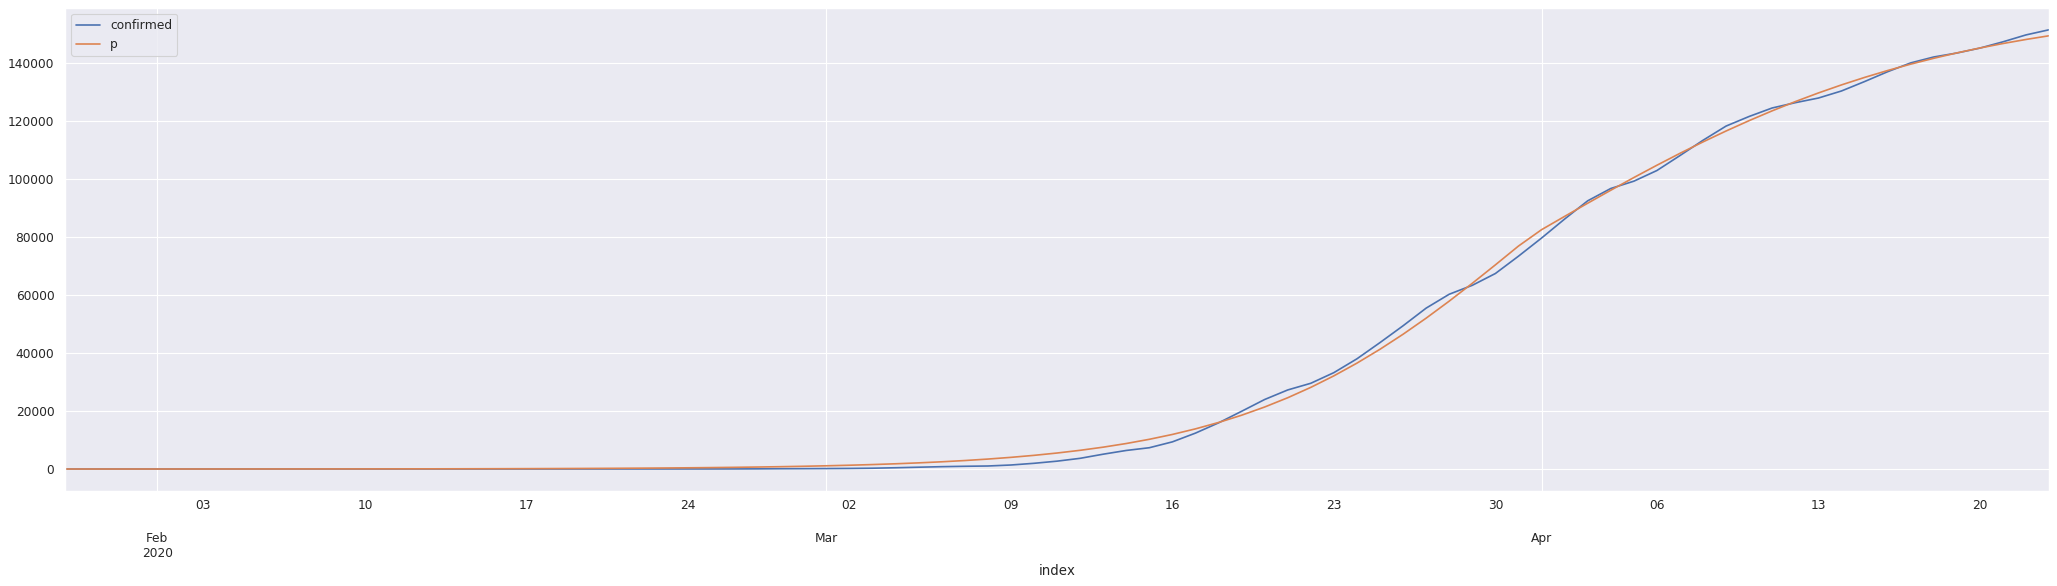

In [20]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ldf1['p'] = fitFunc(ldf1.x, *popt)
ldf1[['confirmed', 'p']].plot(ax=ax)

In [21]:
ldf1['p_diff'] = discrete_diff(ldf1['p'])

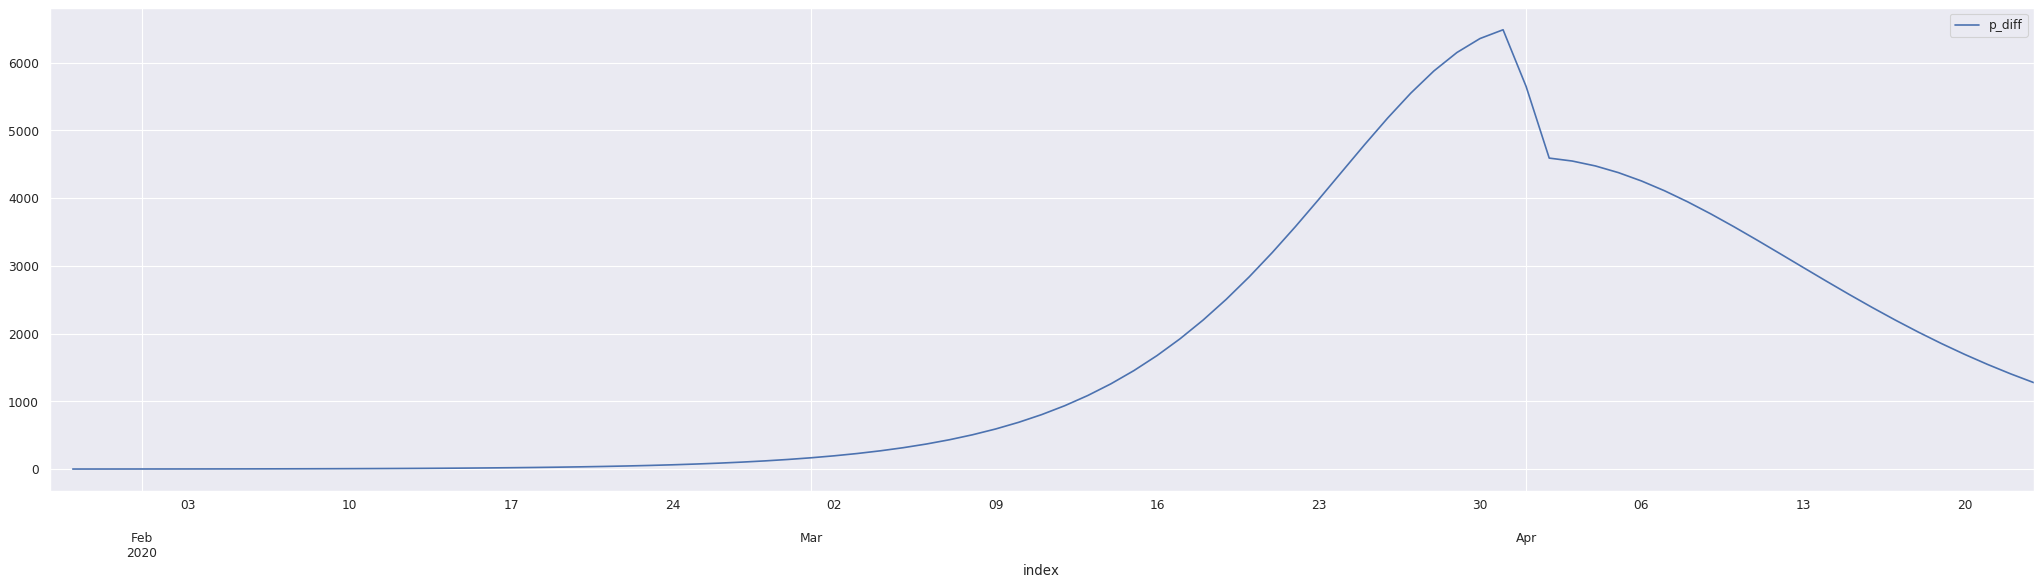

In [22]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ldf1[['p_diff']].plot(ax=ax)

In [42]:
# Derivative of the sigmoid fit function
def fitSigDerivative(t, a, b, c):
    s=covid19.fitSig(t,1,b,c)
    return a*b*s*(1-s)

In [24]:
import sympy

In [167]:
st, sa, sb, sc, sn = sympy.symbols('t a b c n')
st, sa, sb, sc, sn

(t, a, b, c, n)

In [31]:
fnsig = sa / (1 + sympy.exp(-sb * st - sc))
fnsig

a/(exp(-b*t - c) + 1)

In [35]:
d1 = sympy.diff(fnsig, st)
d1

a*b*exp(-b*t - c)/(exp(-b*t - c) + 1)**2

In [36]:
s = fnsig.subs(sa,1)
d2 = sa*sb*s*(1-s)
d2

a*b*(1 - 1/(exp(-b*t - c) + 1))/(exp(-b*t - c) + 1)

In [38]:
sympy.simplify(d1 - d2)

0

In [76]:
daynr  = ldf1.x
values = ldf1.confirmed_diff
p0 = [max(values) * 3 / 2, 0.2, -10]
fitFunc = fitSigDerivative
popt, pcov = scipy.optimize.curve_fit(fitFunc, daynr, values,  p0)

seor = math.sqrt(sum((values - fitFunc(daynr, *(popt))) ** 2) / (len(daynr) - len(popt)))

popt, seor

(array([162917.88825982,      0.13253418,     -8.57313064]), 729.7139299930745)

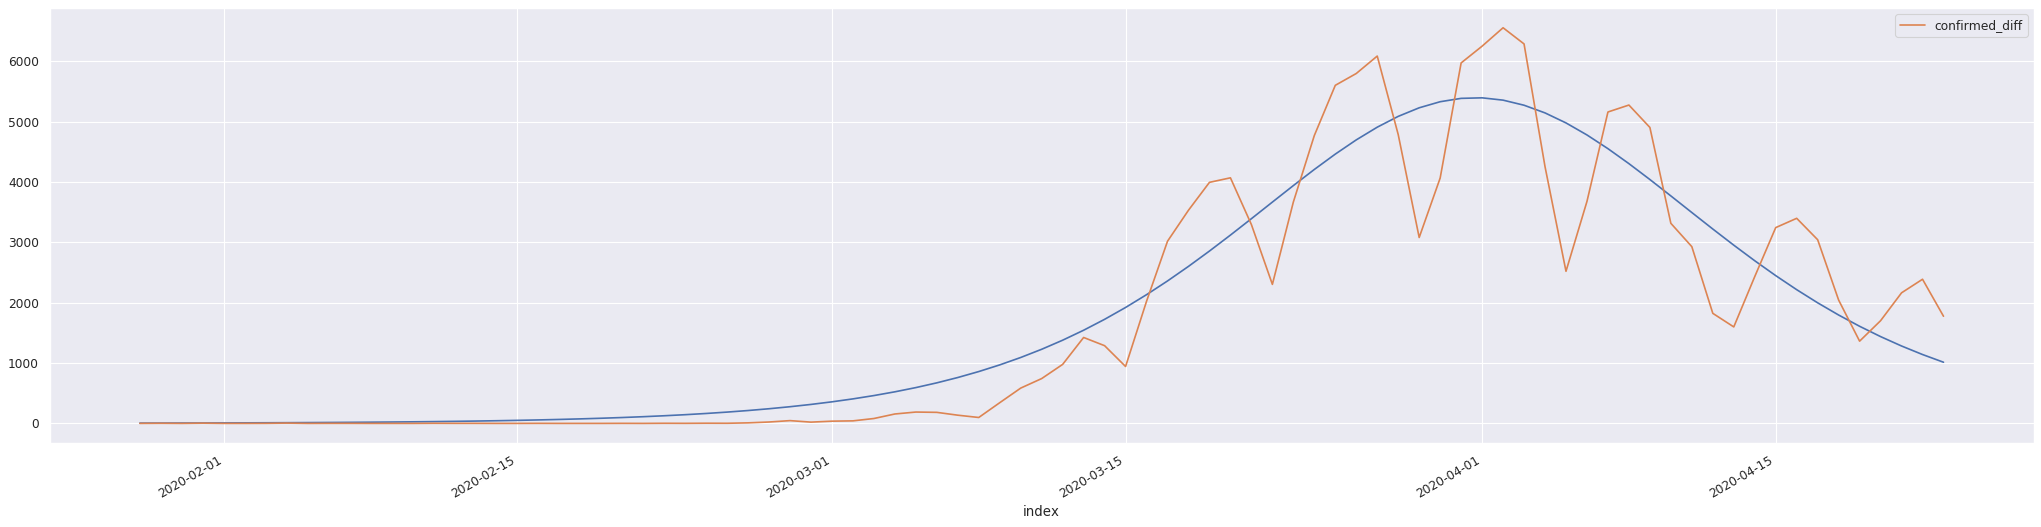

In [77]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ax.plot(ldf1.index, fitFunc(ldf1.x, *popt))
ax = ldf1[['confirmed_diff']].plot(ax=ax)

In [85]:
# -b*t -c == 0 => t = -c/b
# b1*t+c = b2*t+c2 at -c/b => c2=b2*c/b1
def fitSigDerivativeAsymmetric(t, a, b1, b2, c):
    ti = b1*t+c
    negative  = (-np.sign(ti) + np.abs(np.sign(ti)))/2.0
    positive  = (np.sign(ti)  + np.abs(np.sign(ti)))/2.0
    b = negative * b1 + positive * b2
    c = negative * c + positive * b2/b1*c
    a = negative * a + positive * b1/b2*a
    return fitSigDerivative(t, a, b, c)

In [108]:
daynr  = ldf1.x
values = ldf1.confirmed_diff
p0 = [max(values) * 3 / 2, 0.2, 0.2, -10]
fitFunc = fitSigDerivativeAsymmetric
popt, pcov = scipy.optimize.curve_fit(fitFunc, daynr, values,  p0)

seor = math.sqrt(sum((values - fitFunc(daynr, *(popt))) ** 2) / (len(daynr) - len(popt)))

popt, seor

(array([112576.16250189,      0.18835863,      0.09306915,    -11.39433613]),
 682.8238794261899)

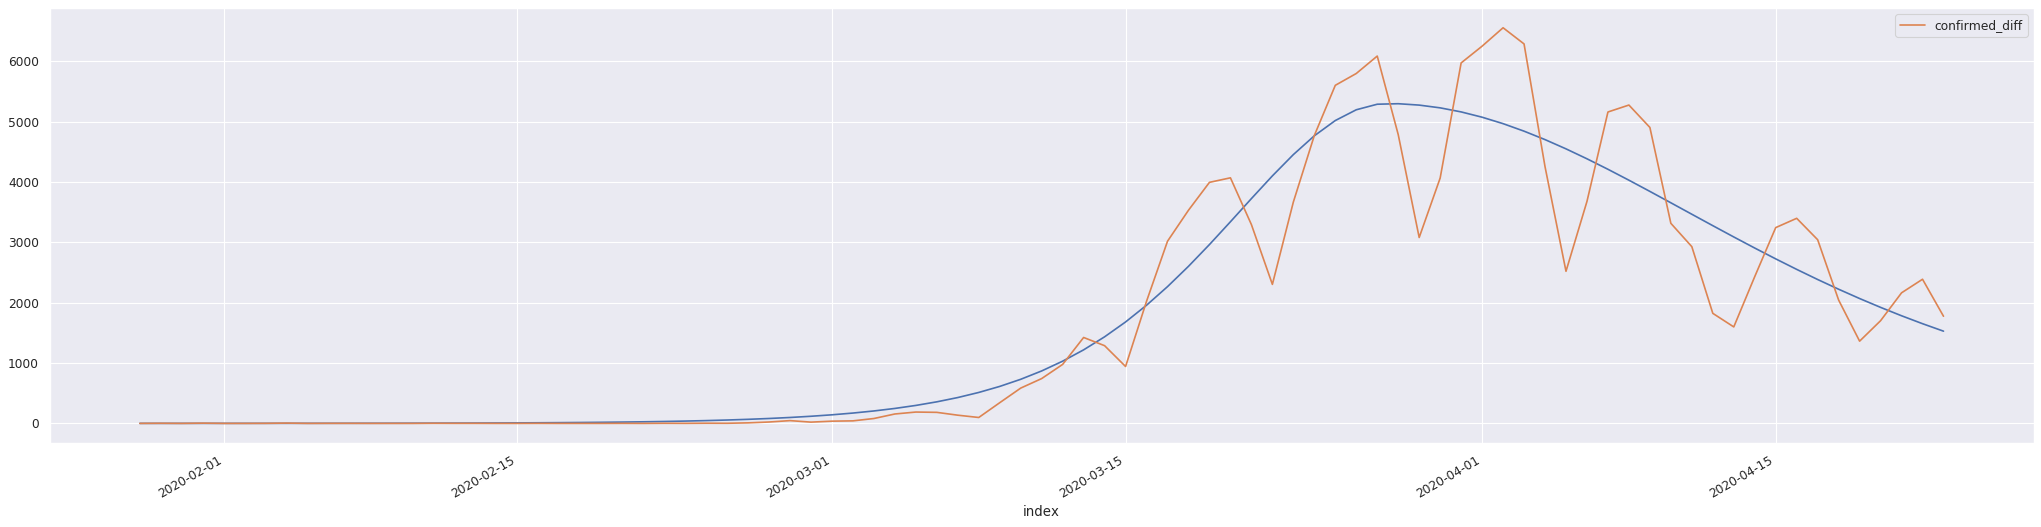

In [109]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ax.plot(ldf1.index, fitFunc(ldf1.x, *popt))
ax = ldf1[['confirmed_diff']].plot(ax=ax)

In [110]:
t = ldf1.x
a, b1, b2, c = popt 
ti = b1*t+c
negative  = (-np.sign(ti) + np.abs(np.sign(ti)))/2.0
positive  = (np.sign(ti)  + np.abs(np.sign(ti)))/2.0
b = negative * b1 + positive * b2
# c = negative * c + positive * b2/b1*c
# a = negative * a + positive * b2/b1*a

In [121]:
l = len(positive[positive == 0])

In [124]:
d = 2
t.iloc[l-d:l+d]

index
2020-03-26    59.0
2020-03-27    60.0
2020-03-28    61.0
2020-03-29    62.0
Freq: D, Name: x, dtype: float64

In [125]:
b.iloc[l-d:l+d]

index
2020-03-26    0.188359
2020-03-27    0.188359
2020-03-28    0.093069
2020-03-29    0.093069
Freq: D, Name: x, dtype: float64

In [126]:
(negative * c + positive * b2/b1*c).iloc[l-d:l+d]

index
2020-03-26   -11.394336
2020-03-27   -11.394336
2020-03-28    -5.630011
2020-03-29    -5.630011
Freq: D, Name: x, dtype: float64

In [127]:
(negative * a + positive * b1/b2*a).iloc[l-d:l+d]

index
2020-03-26    112576.162502
2020-03-27    112576.162502
2020-03-28    227838.032555
2020-03-29    227838.032555
Freq: D, Name: x, dtype: float64

In [136]:
60*b1+c

-0.09281805293537104

In [137]:
61*b2-5.630011

0.04720721058563271

In [75]:
fitSigDerivative(65, 169175, 0.133659, -8.717894)

5651.663604171219

In [81]:
fitSigDerivative(65, -159625.851647, -0.126114, 8.225775)

5031.751492659901

In [82]:
169175 * 0.133659

22611.761325

In [83]:
-159625.851647 * -0.126114

20131.054654609758

In [152]:
covid19.fitSig(60,a,b1, c)

53677.680021401284

In [148]:
a/2

56288.08125094317

In [139]:
covid19.fitSig(61,227838.032555,b2, -5.630011)

116607.41652862821

In [153]:
b1/b2*a/2

113919.01627769244

In [154]:
b1/b2*a/2 - a/2

57630.93502674927

In [142]:
116607 - 53677

62930

In [147]:
(b1/b2*a-a)/2

57630.93502674927

In [164]:
def fitSigAsymmetric(t, a, b1, b2, c):
    ti = b1*t+c
    negative  = (-np.sign(ti) + np.abs(np.sign(ti)))/2.0
    positive  = (np.sign(ti)  + np.abs(np.sign(ti)))/2.0
    b = negative * b1 + positive * b2
    c = negative * c + positive * b2/b1*c
    dt = positive * (b1/b2-1)*a/2.0
    a = negative * a + positive * b1/b2*a
    return covid19.fitSig(t, a, b, c) - dt

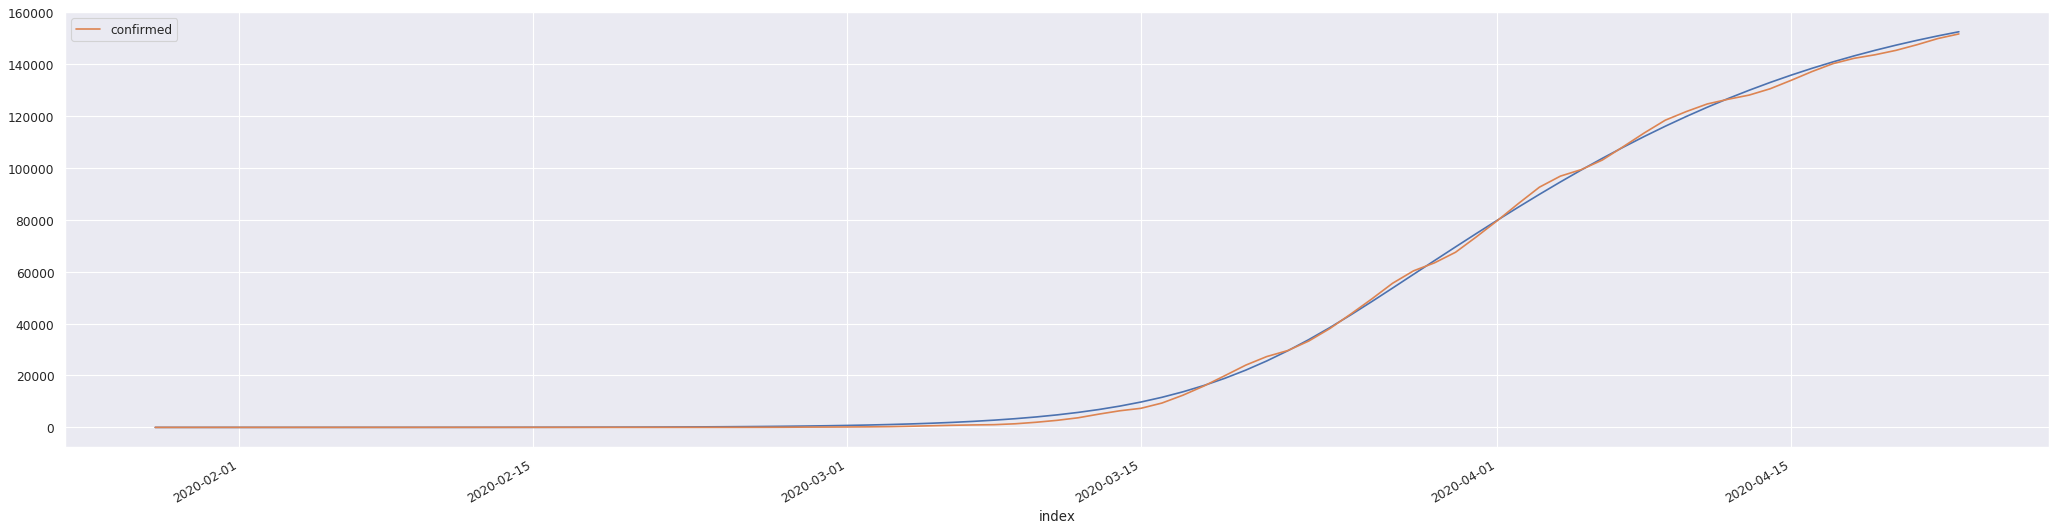

In [166]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ax.plot(ldf1.index, fitSigAsymmetric(ldf1.x, *popt))
ax = ldf1[['confirmed']].plot(ax=ax)

In [198]:
fnsigext = sa / (1 + sympy.exp(-sb * st - sc)) + sn*sympy.log(1+sympy.exp(sb*st + sc))
fnsigext

a/(exp(-b*t - c) + 1) + n*log(exp(b*t + c) + 1)

In [199]:
sympy.diff(fnsigext, st)

a*b*exp(-b*t - c)/(exp(-b*t - c) + 1)**2 + b*n*exp(b*t + c)/(exp(b*t + c) + 1)

In [172]:
# Derivative of the extended sigmoid fit function, with continued flat tail
def fitSigExtDerivative(t, a, b, c, n):
    s=covid19.fitSig(t,1,b,c)
    return a*b*s*(1-s) + covid19.fitSig(t, n*b, b,c)

In [263]:
daynr  = ldf1.x
values = ldf1.confirmed_diff
p0 = [max(values) * 3 / 2, 0.2, -10, 100]
fitFunc = fitSigExtDerivative
popt, pcov = scipy.optimize.curve_fit(fitFunc, daynr, values,  p0)

seor = math.sqrt(sum((values - fitFunc(daynr, *(popt))) ** 2) / (len(daynr) - len(popt)))

popt, seor

(array([113362.83779863,      0.16351576,    -10.10836009,  10210.97158394]),
 681.8456984057556)

In [270]:
popt1 = np.array([popt[0],popt[1],popt[1],popt[2],popt[3]])
popt1

array([113362.83779863,      0.16351576,      0.16351576,    -10.10836009,  10210.97158394])

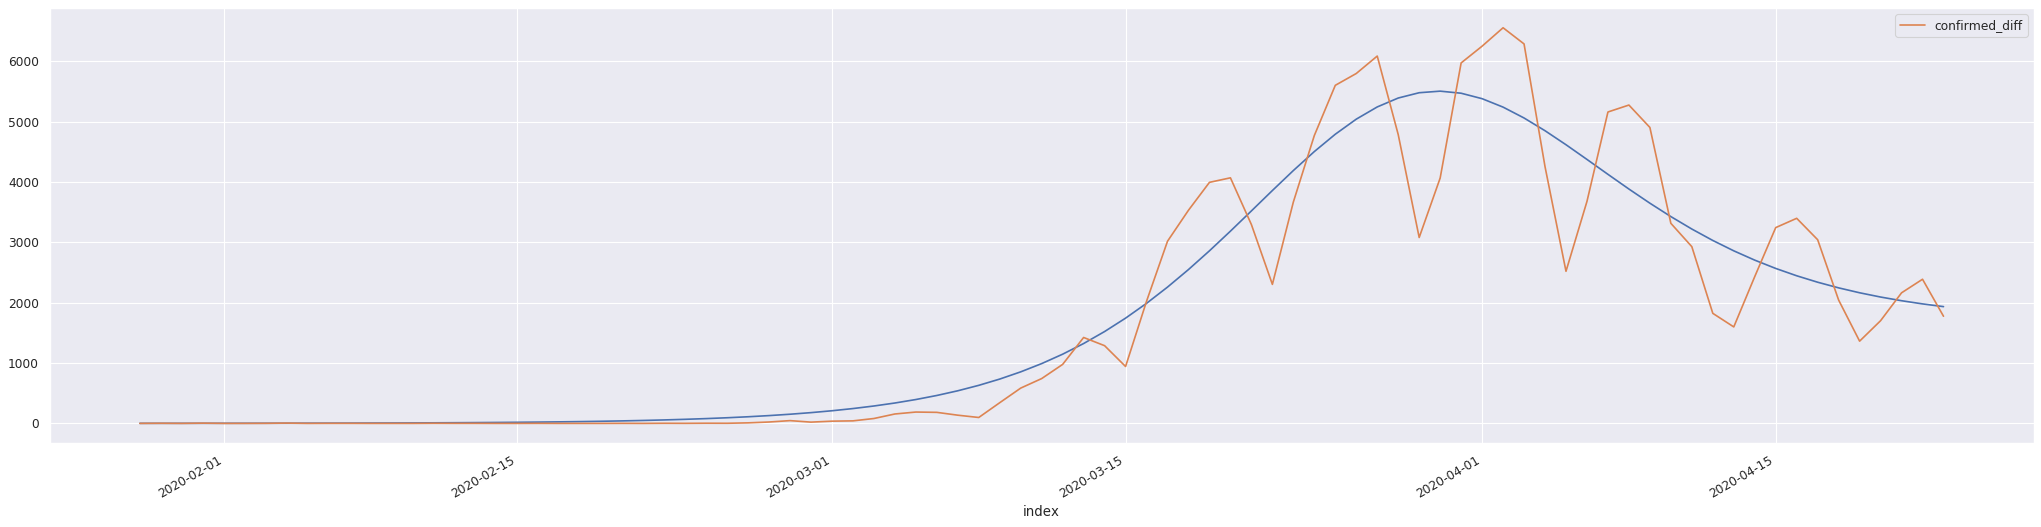

In [264]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ax.plot(ldf1.index, fitFunc(ldf1.x, *popt))
ax = ldf1[['confirmed_diff']].plot(ax=ax)

In [320]:
def fitSigExtDerivativeAsymmetric(t, a, b1, b2, c, n):
    ti = b1*t+c
    negative  = (-np.sign(ti) + np.abs(np.sign(ti)))/2.0
    positive  = (np.sign(ti)  + np.abs(np.sign(ti)))/2.0
    b = negative * b1 + positive * b2
    c = negative * c + positive * b2/b1*c
    a = negative * a + positive * (a*b1/4+b1*n/2-b2*n/2)*4/b2
    return fitSigExtDerivative(t, a, b, c, n)

In [321]:
daynr  = ldf1.x
values = ldf1.confirmed_diff
p0 = [max(values) * 3 / 2, 0.2, 0.2, -10, 100]
fitFunc = fitSigExtDerivativeAsymmetric
popt, pcov = scipy.optimize.curve_fit(fitFunc, daynr, values,  popt1)

seor = math.sqrt(sum((values - fitFunc(daynr, *(popt))) ** 2) / (len(daynr) - len(popt)))

popt, seor

(array([98187.34171371,     0.18363937,     0.12251327,   -11.08542793,  9431.83881701]),
 683.0301128132319)

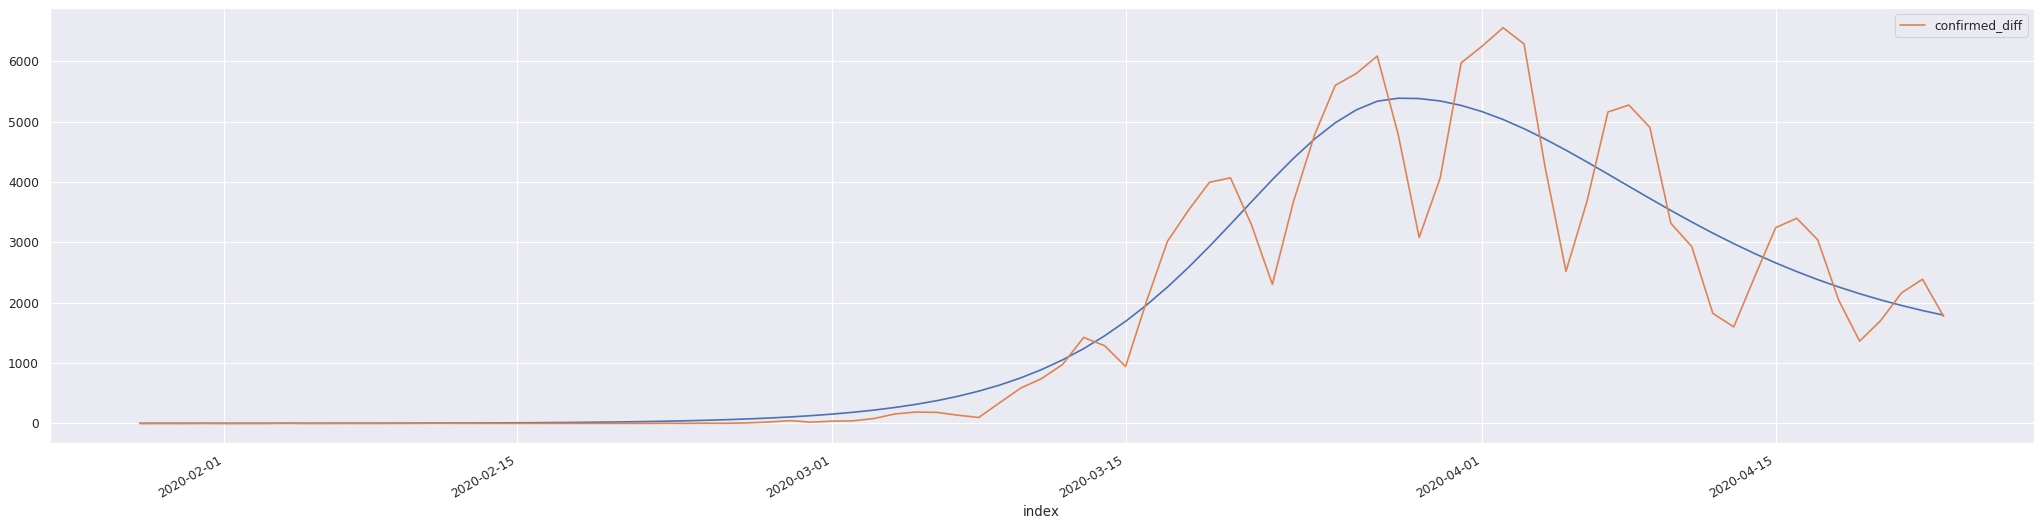

In [322]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ax.plot(ldf1.index, fitFunc(ldf1.x, *popt))
ax = ldf1[['confirmed_diff']].plot(ax=ax)

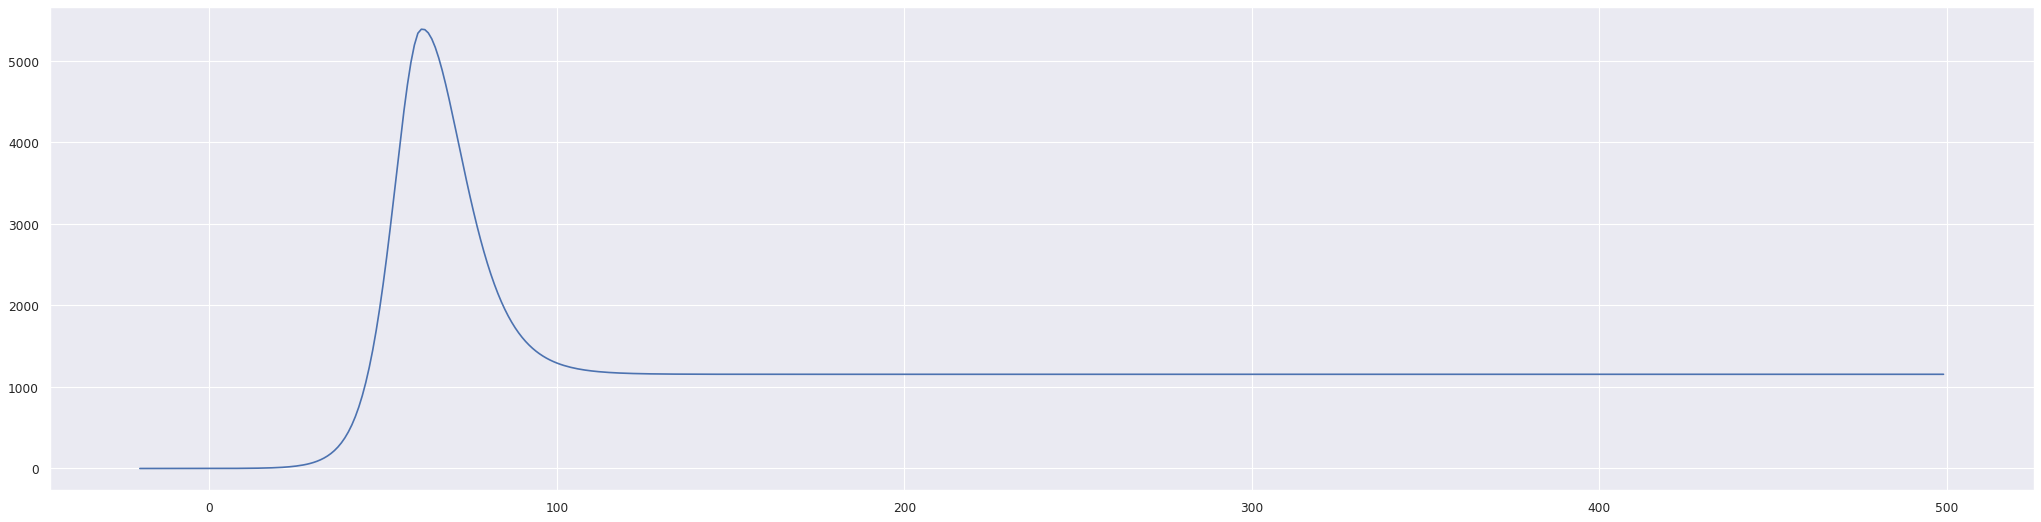

In [323]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
x = np.arange(-20,500) * 1.0
ax.plot(x, fitFunc(x, *popt))

In [324]:
# fitFunc(x, *popt)

In [325]:
popt

array([98187.34171371,     0.18363937,     0.12251327,   -11.08542793,  9431.83881701])

In [326]:
popt[2] * popt[4]

1155.525403531403

In [327]:
def fn_minimize(x, y, fitFunc):
    def f(params):
        return np.sum((y-fitFunc(x, *params))**2)
    
    return f

In [328]:
daynr  = ldf1.x
values = ldf1.confirmed_diff
lf = fn_minimize(daynr, values, fitSigExtDerivativeAsymmetric)
lf(popt)

38255471.07079182

In [329]:
popt

array([98187.34171371,     0.18363937,     0.12251327,   -11.08542793,  9431.83881701])

In [330]:
p0

[9835.5, 0.2, 0.2, -10, 100]

In [331]:
daynr  = ldf1.x
values = ldf1.confirmed_diff
fitFunc = fitSigExtDerivativeAsymmetric
lf = fn_minimize(daynr, values, fitFunc)
res = scipy.optimize.minimize(lf, popt1, method='L-BFGS-B', bounds=((10.0,None), (0.0001,None), (0.0001,None), (None,None), (10.0,None)), options=dict(maxiter=100))# 
seor = math.sqrt(sum((values - fitFunc(daynr, *(popt))) ** 2) / (len(daynr) - len(popt)))
res, seor

(      fun: 38563825.82511713
  hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
       jac: array([  26.82209015, -674.27754402,  104.30812836,   -2.98023224,  116.22905731])
   message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
      nfev: 144
       nit: 17
    status: 0
   success: True
         x: array([113362.83779272,      0.16329376,      0.15685513,    -10.08054424,  10210.97156036]),
 683.0301128132319)

In [332]:
# scipy.optimize.show_options(solver='minimize', method='L-BFGS-B')

In [339]:
popt1

array([113362.83779863,      0.16351576,      0.16351576,    -10.10836009,  10210.97158394])

In [333]:
popt

array([98187.34171371,     0.18363937,     0.12251327,   -11.08542793,  9431.83881701])

In [335]:
popt[2]*popt[4]

1155.525403531403

In [334]:
res.x

array([113362.83779272,      0.16329376,      0.15685513,    -10.08054424,  10210.97156036])

In [336]:
res.x[2]*res.x[4]

1601.6432434767182

In [340]:
popt1[2]*popt1[4]

1669.654770779653

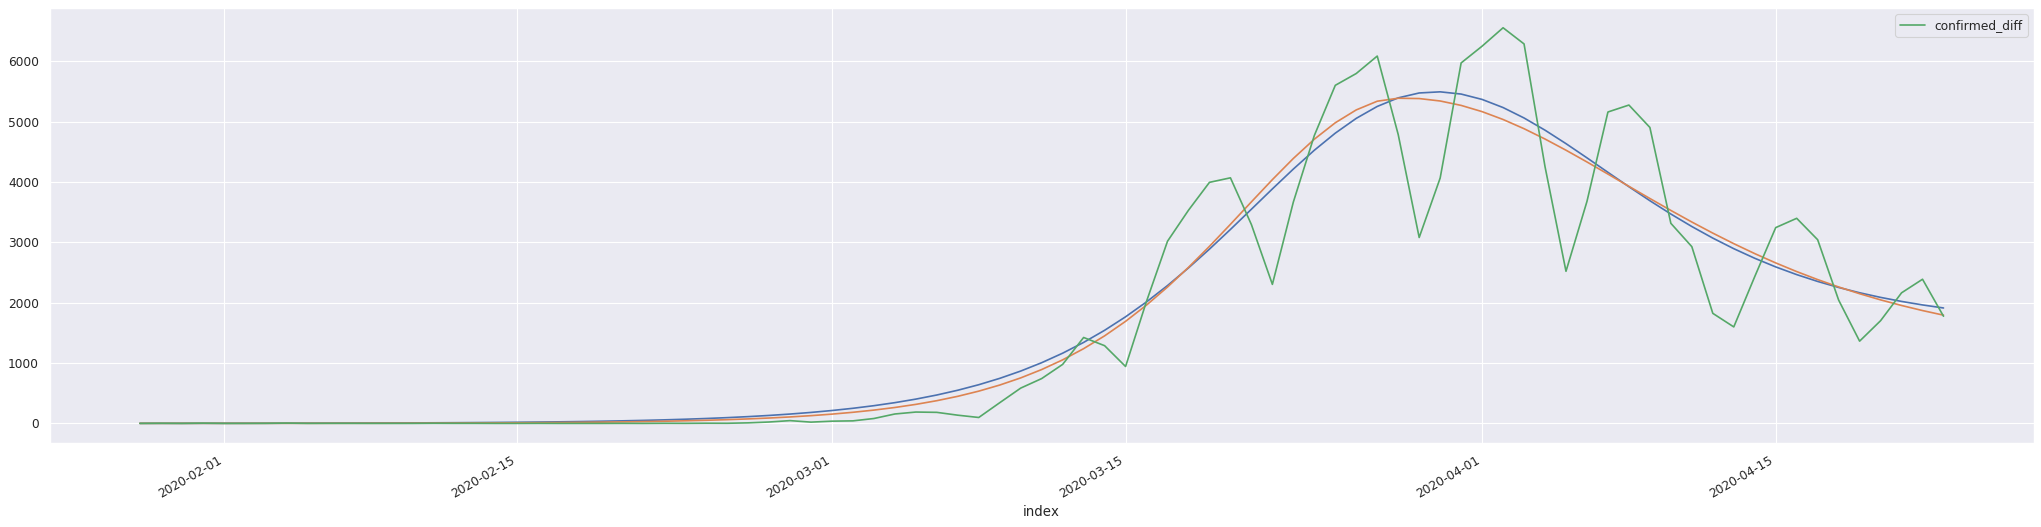

In [341]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ax.plot(ldf1.index, fitFunc(ldf1.x, *res.x))
ax.plot(ldf1.index, fitFunc(ldf1.x, *popt))
#ax.plot(ldf1.index, fitFunc(ldf1.x, *popt1))
ldf1[['confirmed_diff']].plot(ax=ax)

In [357]:
def fitSigExtAsymmetric(t, a, b1, b2, c, n):
    ti = b1*t+c
    negative  = (-np.sign(ti) + np.abs(np.sign(ti)))/2.0
    positive  = (np.sign(ti)  + np.abs(np.sign(ti)))/2.0
    
    b = negative * b1 + positive * b2
    c = negative * c + positive * b2/b1*c

    a1 = a
    a2 = (a*b1/4+b1*n/2-b2*n/2)*4/b2
    dt = positive * (a2-a1)/2.0
    
    a = negative * a1 + positive * a2
    return covid19.fitSigExt(t, a, b, c, n) - dt

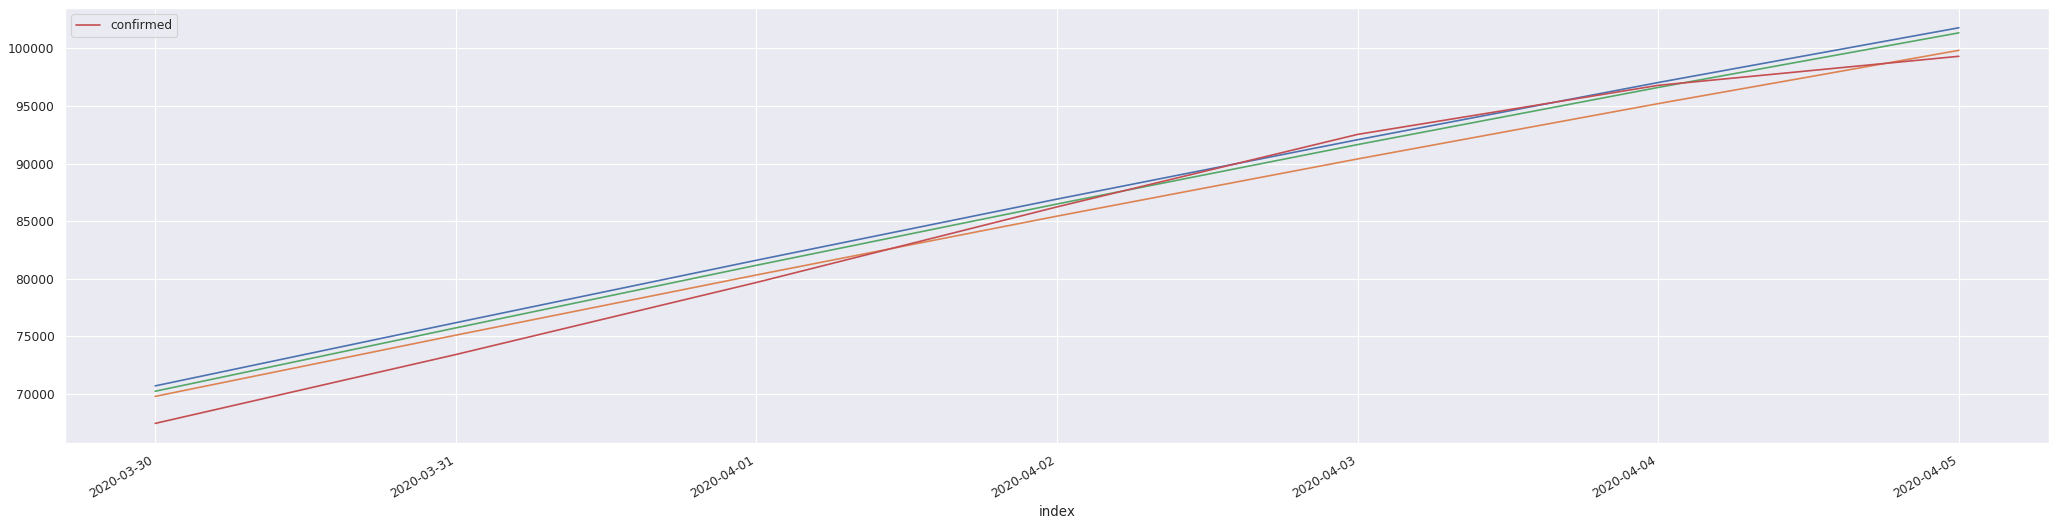

In [361]:
ldf = ldf.loc[pd.to_datetime('2020-03-30'):pd.to_datetime('2020-04-15')]
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ax.plot(ldf.index, fitSigExtAsymmetric(ldf.x, *res.x))
ax.plot(ldf.index, fitSigExtAsymmetric(ldf.x, *popt))
ax.plot(ldf.index, fitSigExtAsymmetric(ldf.x, *popt1))
ax = ldf[['confirmed']].plot(ax=ax)